In [84]:
# pip install xgboost

In [122]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [86]:
# Load JSON data into a DataFrame
df = pd.read_csv('dataset1.csv')

FEATURE ENGINEERING AND EXRTACTION

In [87]:
# categorize trafficIDs from strings that contain letters and numbers to just numbers
df['trafficID'] = df['trafficID'].astype('category').cat.codes

In [88]:
# Convert timestamps to datetime if they aren't already
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

# Extract date and time components
df['hour'] = df['timeStamp'].dt.hour
df['minute'] = df['timeStamp'].dt.minute
df['second'] = df['timeStamp'].dt.second


# Assumption: 70% of cars go forward, 20% turn left, 10% turn right.
# These assumptions will be replaced with actual data in the future using sensors.
df['forward_flow'] = round(df['num_cars'] * 0.7)
df['left_flow'] = round(df['num_cars'] * 0.2)
df['right_flow'] = round(df['num_cars'] * 0.1)

# Calculate flow ratios for each direction
df['forward_flow_ratio'] = df['forward_flow'] / df['num_cars']
df['left_flow_ratio'] = df['left_flow'] / df['num_cars']
df['right_flow_ratio'] = df['right_flow'] / df['num_cars']


In [89]:
# Temporal Features based on trafficID
df['time_since_last_green'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().fillna(0)

# Average time between green signals
df['avg_time_between_greens'] = df.groupby('trafficID')['timeStamp'].diff().dt.total_seconds().groupby(df['trafficID']).transform('mean').fillna(0)

In [90]:
# Peak flow is the maximum flow of cars in any direction categorized into  0, 1, 2
# 0: forward flow, 1: left flow, 2: right flow
df['peak_flow'] = df[['forward_flow', 'left_flow', 'right_flow']].idxmax(axis=1).astype('category').cat.codes


In [91]:
def categorize_time_of_day(hour):
    '''Categorize the time of day based on the hour of the day.'''
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['part_of_day'] = df['hour'].apply(categorize_time_of_day)

In [92]:
# Calculate the difference in car count between consecutive time stamps by traffic ID
df['car_count_diff'] = df.groupby('trafficID')['num_cars'].diff()

In [93]:
# Calculate the exponential moving average of the number of cars
df['ema_cars'] = df['num_cars'].ewm(span=10, adjust=False).mean()

In [94]:
# Create a columns to indicate whether the day is a weekend or not
df['weekday'] = df['timeStamp'].dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [95]:
# Create a column to indicate whether the day is a public holiday or not
public_holidays = set(['2024-09-23', '2025-02-22']) # Saudi National Day and Founding Day of the Kingdom of Saudi Arabia
df['is_public_holiday'] = df['timeStamp'].dt.date.astype(str).isin(public_holidays).astype(int)

In [96]:
# Create a column to indicate the time of day as a sin/cos pair
period = 7 * 24  # 7 days * 24 hours
df['sin_time'] = np.sin(2 * np.pi * df['timeStamp'].dt.hour / period)
df['cos_time'] = np.cos(2 * np.pi * df['timeStamp'].dt.hour / period)


In [97]:
# Removing NaN values from car_count_diff column and setting them to 0
df['car_count_diff'].fillna(value=0, inplace=True)
# df['weatherStamp:'].fillna(value=30, inplace=True)

In [98]:
# Group by date and trafficID, calculate the mean of the 3 flow directions, then calculate the mean of the 3 flow directions
daily_std_dev = df.groupby(['dateStamp', 'trafficID'])[['forward_flow', 'left_flow', 'right_flow']].std().mean(axis=1).reset_index()

# Rename the column for clarity
daily_std_dev.columns = ['dateStamp', 'trafficID', 'daily_std_dev']

# Merge the daily standard deviation back to the original DataFrame
df = pd.merge(df, daily_std_dev, on=['dateStamp', 'trafficID'])

In [99]:
# Data handling before model training
# convert timestamp to numeric
df['timeStamp_numeric'] = df['timeStamp'].apply(lambda x: x.timestamp())
# convert dateStamp from str to datetime then to numeric
df['dateStamp'] = pd.to_datetime(df['dateStamp'])
df['dateStamp_numeric'] = df['dateStamp'].apply(lambda x: x.timestamp())
# drop the original timestamp and datestamp columns
df.drop(['timeStamp', 'dateStamp'], axis=1, inplace=True)

In [100]:
# change part_of_day to categories and then to numeric
df['part_of_day'] = df['part_of_day'].astype('category').cat.codes  # convert to numeric

In [101]:
# Dropping unneeded columns
# Drop hour, min, second
df.drop(['hour', 'minute', 'second'], axis=1, inplace=True)

# drop flow ratios
df.drop(['forward_flow_ratio', 'left_flow_ratio', 'right_flow_ratio'], axis=1, inplace=True)

# drop timeStamp_numeric
df.drop(['timeStamp_numeric'], axis=1, inplace=True)

# drop weatherStamp:
df.drop(['weatherStamp:'], axis=1, inplace=True)



In [102]:
# Convert all str columns in df to numeric (float)
for col in df.columns:
    if df[col].dtype == 'str':
        df[col] = pd.to_numeric(df[col], errors='coerce', inplace=True)

In [103]:
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

trafficID: int8
num_cars: int64
greenTime: int64
forward_flow: float64
left_flow: float64
right_flow: float64
time_since_last_green: float64
avg_time_between_greens: float64
peak_flow: int8
part_of_day: int8
car_count_diff: float64
ema_cars: float64
weekday: int64
is_weekend: int64
is_public_holiday: int32
sin_time: float64
cos_time: float64
daily_std_dev: float64
dateStamp_numeric: float64


In [104]:
# replace Nans with 0 and inf with 1e9
df.fillna(0, inplace=True)

Normalization

In [105]:
# Prepare the scaler
scaler = StandardScaler()

# Define columns to be scaled
columns_to_normalize = ['num_cars', 'daily_std_dev', 'time_since_last_green', 'avg_time_between_greens', 'ema_cars', 'car_count_diff', 'forward_flow', 'left_flow', 'right_flow']

# Normalize these columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


XGBoost Model

In [106]:
# Split the data into input features and target
# Define your features and target variable
feature_cols = ['trafficID', 'num_cars', 'forward_flow', 'left_flow',
                'right_flow', 'time_since_last_green', 'avg_time_between_greens',
                'peak_flow', 'part_of_day', 'car_count_diff', 'ema_cars', 'weekday',
                'is_weekend', 'is_public_holiday', 'sin_time', 'cos_time',
                'daily_std_dev', 'dateStamp_numeric']

target_col = 'greenTime'

# Split the data into input features and target
X = df[feature_cols]
y = df[target_col]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [124]:
# Define the model
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         colsample_bytree = 0.3, 
                         learning_rate = 0.1,
                         max_depth = 5, 
                         alpha = 10, 
                         n_estimators = 10000)

# Train the model
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 2.0893915526752567


In [125]:
model2 = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid
param_grid = {
    'colsample_bytree': [0.3, 0.7],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'alpha': [5, 10],
    'n_estimators': [100, 1000, 10000]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model2, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE: ", -grid_search.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'alpha': 5, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}
Best RMSE:  1.5991979096281728


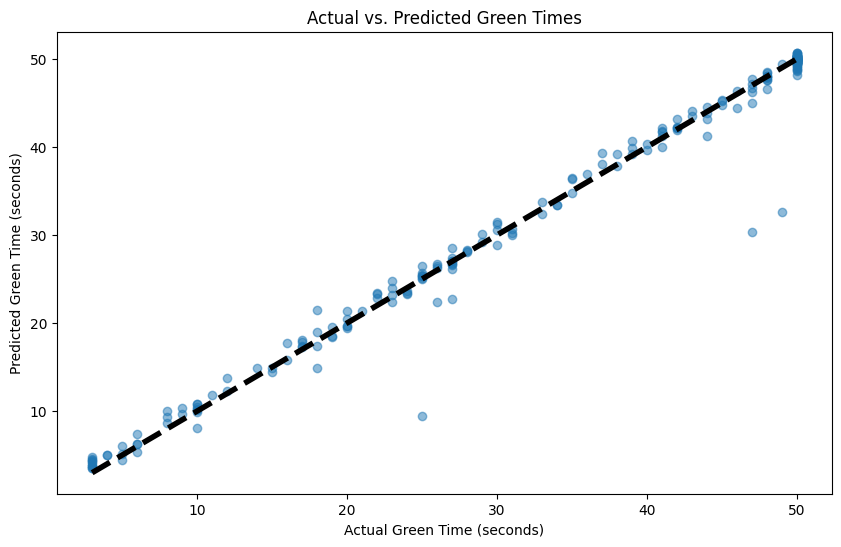

In [118]:
# Assuming `predictions` are stored in `predictions` and `y_test` are the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.title('Actual vs. Predicted Green Times')
plt.xlabel('Actual Green Time (seconds)')
plt.ylabel('Predicted Green Time (seconds)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()


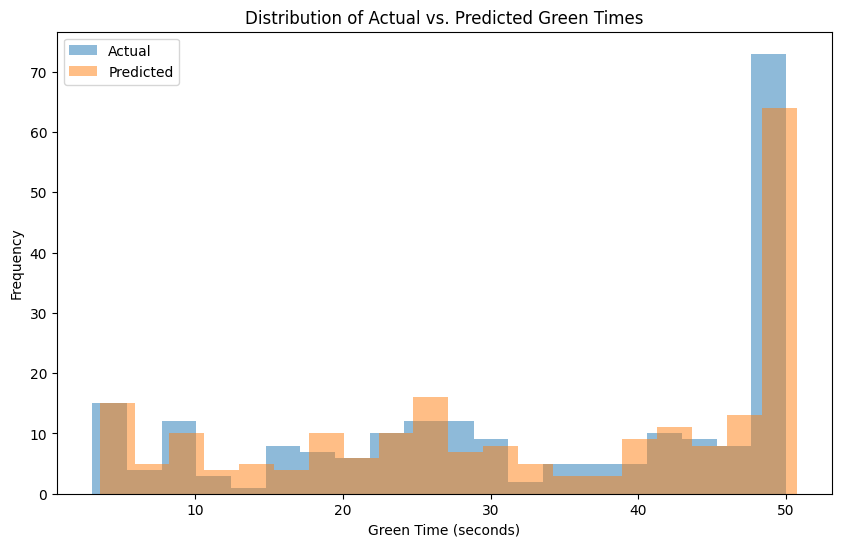

In [119]:
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=20, alpha=0.5, label='Actual')
plt.hist(predictions, bins=20, alpha=0.5, label='Predicted')
plt.title('Distribution of Actual vs. Predicted Green Times')
plt.xlabel('Green Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [113]:
import plotly.express as px

fig = px.scatter(x=y_test, y=predictions, labels={'x': 'Actual Green Time', 'y': 'Predicted Green Time'},
                 title='Actual vs Predicted Green Times')
fig.add_shape(type='line', x0=y_test.min(), y0=y_test.min(), x1=y_test.max(), y1=y_test.max())
fig.show()
